## Adding a new task to ```spred```
--------------------------------------

In this tutorial, we show how to add a new task for evaluating selective
prediction techniques. Specifically, we'll create a task called "normals",
a two-label classification task. Instances for label A are generated from
a mixture of two bivariate normal distributions with means (-1, 0) and (1, 0),
whereas instances for label B are generated from a mixture of two bivariate
normals with means (0, -1) and (0, 1). The covariances are chosen so that most
overlap occurs near the origin, making such points the "most difficult" to 
classify.

![samples from the two mixture distributions](red_blue.png)

For most tasks, we'll already have training data stored in a file somewhere, but for this task, we'll create our own training data. To do so, let's leverage the ```numpy``` package to make a helper function ```generate_samples``` that samples points from a bivariate normal distribution.

In [66]:
from numpy.random import multivariate_normal
from numpy import diag

def generate_samples(means, variances, num_samples, noise_dim=0):
    return multivariate_normal(means + [0.0]*noise_dim,
                               diag(variances + [1.0]*noise_dim),
                               size=num_samples)


The function assumes that the two dimensions are not correlated, so if we make the following call, then we're effectively drawing our ```x``` coordinate from ```Normal(-1.0, 0.2)``` and our ```y``` coordinate from ```Normal(0.0, 0.1)```.

In [69]:
generate_samples(means=[-1.0, 0.0], variances=[0.2, 0.1], num_samples=5)

array([[-0.61135898, -0.08789313],
       [-1.16175929, -0.50912341],
       [-1.37709625,  0.02869998],
       [-1.31960289, -0.22252163],
       [-1.05692077,  0.0113179 ]])

We've also provided an argument called ```noise_dim```, to make the learning task a bit more challenging. This adds extra dimensions, each independently sampled from a standard zero-mean normal.

In [70]:
generate_samples(means=[-1.0, 0.0], variances=[0.2, 0.1], num_samples=5, noise_dim=3)

array([[-1.60605609,  0.24326898,  0.12657275,  0.30437083,  0.57061419],
       [-1.41459962, -0.13684672, -1.02059566, -0.52152583,  0.57735206],
       [-1.40828992,  0.15737815,  0.76787348,  0.15738372, -0.46348617],
       [-0.35372335, -0.22188655, -0.2727551 ,  0.72317812,  0.92209704],
       [-1.29291253, -0.69319441, -0.73052094, -0.44792217, -0.06139822]])

We now need to create a ```Loader``` for this training data, which implements the interface in ```spred.loader```:

    class Loader(ABC):
        @abstractmethod
        def __iter__(self):
            """
            Creates an Iterator over the batches of the Loader.
    
            Each batch should be a dictionary with at least two keys:
            - "inputs": maps to a torch.tensor of shape BxD containing the input
            vectors, where B is batch size and D is input vector dimension
            - "labels": maps to a torch.tensor of shape B containing the
            corresponding labels
    
            """
            ...
    
        @abstractmethod
        def __len__(self):
            """ Number of batches provided by the Loader."""
            ...
    
        @abstractmethod
        def num_labels(self):
            """ Number of class labels in the dataset. """
            ...


In [71]:
import numpy
import torch
from random import shuffle
from spred.loader import Loader

class NormalsLoader(Loader):
    
    def __init__(self, num_batches, bsz, noise_dim):
        super().__init__()
        self.bsz = bsz
        self.num_batches = num_batches
        self.noise_dim = noise_dim
        self.batches = []
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        for _ in range(num_batches):
            variance1 = 0.2
            variance2 = 0.1
            pts1a = generate_samples([-1.0, 0.0], [variance1, variance2], bsz//4, self.noise_dim)
            pts1b = generate_samples([1.0, 0.0], [variance1, variance2], bsz//4, self.noise_dim)
            pts2a = generate_samples([0.0, -1.0], [variance2, variance1], bsz//4, self.noise_dim)
            pts2b = generate_samples([0.0, 1.0], [variance2, variance1], bsz//4, self.noise_dim)
            labeled = ([(pt, 0) for pt in pts1a] +
                       [(pt, 0) for pt in pts1b] +
                       [(pt, 1) for pt in pts2a] +
                       [(pt, 1) for pt in pts2b])
            shuffle(labeled)
            instances = torch.tensor(numpy.array([pair[0] for pair in labeled])).float()
            labels = torch.tensor([pair[1] for pair in labeled])
            self.batches.append((instances, labels))

    def __iter__(self):
        for instances, labels in self.batches:
            yield {'inputs': instances.to(self.device), 'labels': labels.to(self.device)}

    def __len__(self):
        return self.num_batches

    def num_labels(self):
        return 2

For instance, the following code creates a ```Loader``` that provides two batches, each with eight training vectors (half of which are sampled from class 0 and half of which are sampled from class 1).

In [72]:
loader = NormalsLoader(num_batches=2, bsz=8, noise_dim=3)
print('This loader has {} batches.'.format(len(loader)))
print('This loader has {} class labels.'.format(loader.num_labels()))
for batch in loader:
    print(batch)

This loader has 2 batches.
This loader has 2 class labels.
{'inputs': tensor([[ 0.0551,  0.0817, -1.1637,  0.7265, -0.7090],
        [-0.1584,  1.0086, -0.7642, -1.7295, -0.7458],
        [ 1.5703,  0.4630,  0.2770, -0.4500, -0.8754],
        [-1.8031,  0.0947,  1.9715,  0.4066,  1.2375],
        [ 0.3472, -1.0696, -0.4476, -0.1197, -1.2792],
        [ 0.3313,  1.4797,  1.7097, -0.5617,  1.0999],
        [-0.6364, -0.0967,  0.7562,  0.5083, -1.0223],
        [ 0.0846, -0.2786,  0.1938,  0.9439, -1.3372]]), 'labels': tensor([1, 1, 0, 0, 1, 1, 0, 0])}
{'inputs': tensor([[ 0.8403, -0.1670, -1.0769,  1.4602, -0.8209],
        [-0.1525, -1.6424, -0.6308,  0.5023, -0.7919],
        [ 1.0638,  0.0862, -1.8917, -0.2896,  0.4718],
        [-1.1498, -0.3164, -0.2613,  1.5006,  0.2386],
        [ 0.0429, -0.7172, -0.3846,  0.4296,  0.6689],
        [-0.7951,  0.1529, -0.3889, -0.1128,  0.1660],
        [ 0.0593,  0.8141,  0.4782, -0.3582,  0.0250],
        [-0.1093,  1.0440,  0.3392,  0.0300, -1.

With our ```Loader``` defined, we can now create a ```Task``` by specifying the training, validation, and test sets. Task-specific arguments should be provided to the ```Task``` constructor via a configuration dictionary, e.g.:

In [73]:
task_config = {"task": {"name": "normals",
                        "noise_dim": 50,
                        "n_train_batches": 200,
                        "n_validation_batches": 200,
                        "n_test_batches": 100},
               "bsz": 64}

In [74]:
from spred.task import Task

class NormalsTask(Task):

    def __init__(self, config):
        super().__init__(config)

    def init_train_loader(self):
        n_batches = self.config['task']['n_train_batches']
        bsz = self.config['bsz']
        noise_dim = self.config['task']['noise_dim']
        return NormalsLoader(n_batches, bsz, noise_dim)

    def init_validation_loader(self):
        n_batches = self.config['task']['n_validation_batches']
        bsz = self.config['bsz']
        noise_dim = self.config['task']['noise_dim']
        return NormalsLoader(n_batches, bsz, noise_dim)

    def init_test_loader(self):
        n_batches = self.config['task']['n_test_batches']
        bsz = self.config['bsz']
        noise_dim = self.config['task']['noise_dim']
        return NormalsLoader(n_batches, bsz, noise_dim)

2


In [42]:
config = {"network": {"architecture": "feedforward",
                      "input_size": 52,
                      "hidden_sizes": [128, 64],
                      "output_size": 2,
                      "loss": {
                          "name": "ce"
                      }},
          "optimizer": {"name": "sgd",
                        "lr": 0.003,
                        "momentum": 0.9},
          "bsz": 64,
          "n_epochs": 30,
          "confidences": [{"name": "max_prob"},
                          {"name": "random"},
                          {"name": "mcd",
                           "aggregator": "mean",
                           "n_forward_passes": 10}]}


In [54]:
from spred.experiment import Experiment
task = NormalsTask(task_config)
exp = Experiment(config, task)
exp_result = exp.run()

Training with config:
{'network': {'architecture': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30, 'confidences': [{'name': 'max_prob'}, {'name': 'random'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}]}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2016.05it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2059.14it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2049.07it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2038.58it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2029.32it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2037.03it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2042.00it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2047.11it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2008.41it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2023.68it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2026.42it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2049.41it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2035.25it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2058.76it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2030.68it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2045.13it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2052.86it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2034.15it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2059.73it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2044.30it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2056.24it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2060.35it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2052.06it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2063.94it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2055.01it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2042.88it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2046.33it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2049.60it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2026.39it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2061.71it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1746.03it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.864375,
    "aupr": 0.9605712198115013,
    "auroc": 0.7928444600497816,
    "avg_crr_conf": 0.5916855425667018,
    "avg_err_conf": 0.07968598362989723,
    "capacity": 0.9549702016500475,
    "kendall_tau": 0.20715564407835768,
    "n_correct": 5532,
    "n_errors": 868,
    "n_published": 6400,
    "validation_loss": 0.4589270994067192
}


100%|██████████| 100/100 [00:00<00:00, 1858.57it/s]


{'name': 'random'}
{
    "accuracy": 0.864375,
    "aupr": 0.8593913515090716,
    "auroc": 0.48243691500811364,
    "avg_crr_conf": 0.42709464879706505,
    "avg_err_conf": 0.06939081467688084,
    "capacity": 0.8593368932530325,
    "kendall_tau": 0.5175632932481649,
    "n_correct": 5532,
    "n_errors": 868,
    "n_published": 6400,
    "validation_loss": 0.4589270994067192
}


100%|██████████| 100/100 [00:00<00:00, 311.86it/s]

{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.864375,
    "aupr": 0.9436220230886411,
    "auroc": 0.7203173367520684,
    "avg_crr_conf": 0.5502092671347782,
    "avg_err_conf": 0.07707801168784499,
    "capacity": 0.939412636132287,
    "kendall_tau": 0.27968276737607084,
    "n_correct": 5532,
    "n_errors": 868,
    "n_published": 6400,
    "validation_loss": 0.4589270994067192
}


In [56]:
from spred.analytics import ResultDatabase
n_trials = 5
result_db = ResultDatabase([exp.run() for _ in range(n_trials)])


Training with config:
{'network': {'architecture': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30, 'confidences': [{'name': 'max_prob'}, {'name': 'random'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}]}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 1918.63it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2052.61it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2021.16it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2059.67it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2038.15it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2046.83it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2060.30it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 1145.67it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2056.75it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2056.68it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2048.05it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2034.38it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2032.89it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2046.37it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2036.18it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2060.14it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2057.11it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2033.61it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2016.27it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2032.15it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2055.71it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2041.65it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2030.81it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2057.77it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2055.81it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2035.60it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2053.98it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2049.31it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2041.28it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2053.25it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1828.39it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.9025,
    "aupr": 0.9847325621926695,
    "auroc": 0.8765347270313943,
    "avg_crr_conf": 0.7639971074089408,
    "avg_err_conf": 0.06419453774578869,
    "capacity": 0.9809692483570327,
    "kendall_tau": 0.12346541169472264,
    "n_correct": 5776,
    "n_errors": 624,
    "n_published": 6400,
    "validation_loss": 0.2709637603163719
}


100%|██████████| 100/100 [00:00<00:00, 1895.48it/s]


{'name': 'random'}
{
    "accuracy": 0.9025,
    "aupr": 0.9025576018258505,
    "auroc": 0.4893325165139569,
    "avg_crr_conf": 0.4568972721043974,
    "avg_err_conf": 0.050421635573729875,
    "capacity": 0.9025229209545066,
    "kendall_tau": 0.5106674834860431,
    "n_correct": 5776,
    "n_errors": 624,
    "n_published": 6400,
    "validation_loss": 0.2709637603163719
}


100%|██████████| 100/100 [00:00<00:00, 317.23it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.9025,
    "aupr": 0.9794368781144756,
    "auroc": 0.838209695068897,
    "avg_crr_conf": 0.702174401502125,
    "avg_err_conf": 0.060505566257052126,
    "capacity": 0.9760324813183064,
    "kendall_tau": 0.16179044365721998,
    "n_correct": 5776,
    "n_errors": 624,
    "n_published": 6400,
    "validation_loss": 0.2709637603163719
}
Training with config:
{'network': {'architecture': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30, 'confidences': [{'name': 'max_prob'}, {'name': 'random'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}]}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2040.27it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2038.57it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2051.48it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2070.36it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2060.50it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2045.16it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2038.20it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2054.63it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2043.21it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 1961.55it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2064.22it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2055.75it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2048.49it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2045.24it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2045.00it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2052.67it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2056.94it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2046.46it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2050.84it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2039.36it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2044.03it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2055.99it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2038.37it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2040.19it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2066.16it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2046.94it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2049.66it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2056.43it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2049.79it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2055.41it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1838.47it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.9309375,
    "aupr": 0.9932663438601561,
    "auroc": 0.9174599268788002,
    "avg_crr_conf": 0.8399400087632238,
    "avg_err_conf": 0.04402004862204194,
    "capacity": 0.9912084885591689,
    "kendall_tau": 0.08254007312119983,
    "n_correct": 5958,
    "n_errors": 442,
    "n_published": 6400,
    "validation_loss": 0.182403781414032
}


100%|██████████| 100/100 [00:00<00:00, 1916.41it/s]


{'name': 'random'}
{
    "accuracy": 0.9309375,
    "aupr": 0.9303640709223007,
    "auroc": 0.5068074561143692,
    "avg_crr_conf": 0.46390043932944536,
    "avg_err_conf": 0.03395576979033649,
    "capacity": 0.9303418341111653,
    "kendall_tau": 0.4931925438856308,
    "n_correct": 5958,
    "n_errors": 442,
    "n_published": 6400,
    "validation_loss": 0.182403781414032
}


100%|██████████| 100/100 [00:00<00:00, 319.02it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.9309375,
    "aupr": 0.9914233041961835,
    "auroc": 0.8977081653019097,
    "avg_crr_conf": 0.7751339438185095,
    "avg_err_conf": 0.0415589996566996,
    "capacity": 0.9894551733977734,
    "kendall_tau": 0.10229183469809025,
    "n_correct": 5958,
    "n_errors": 442,
    "n_published": 6400,
    "validation_loss": 0.182403781414032
}
Training with config:
{'network': {'architecture': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30, 'confidences': [{'name': 'max_prob'}, {'name': 'random'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}]}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2044.79it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2038.36it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2064.58it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2050.42it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2046.35it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2041.57it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2049.43it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2041.90it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2058.57it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2050.15it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2059.90it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2050.36it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2051.29it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2044.41it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2052.02it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2053.41it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2056.11it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2042.17it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2042.79it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2038.42it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2046.86it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2050.46it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2048.53it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2047.67it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2069.94it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2052.31it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2064.30it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2057.06it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2041.24it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2058.39it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1774.53it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.92765625,
    "aupr": 0.9921897226950944,
    "auroc": 0.9108993968708881,
    "avg_crr_conf": 0.8333713242504746,
    "avg_err_conf": 0.04801446319557726,
    "capacity": 0.9899515841012433,
    "kendall_tau": 0.08910078502461592,
    "n_correct": 5937,
    "n_errors": 463,
    "n_published": 6400,
    "validation_loss": 0.19337327614426614
}


100%|██████████| 100/100 [00:00<00:00, 1744.07it/s]


{'name': 'random'}
{
    "accuracy": 0.92765625,
    "aupr": 0.9274229594062035,
    "auroc": 0.5051714710726123,
    "avg_crr_conf": 0.4660744973085821,
    "avg_err_conf": 0.03597745343111455,
    "capacity": 0.9274072088524458,
    "kendall_tau": 0.49482852892738766,
    "n_correct": 5937,
    "n_errors": 463,
    "n_published": 6400,
    "validation_loss": 0.19337327614426614
}


100%|██████████| 100/100 [00:00<00:00, 317.78it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.92765625,
    "aupr": 0.9896881369662595,
    "auroc": 0.8857059600972195,
    "avg_crr_conf": 0.7663167607644573,
    "avg_err_conf": 0.044979985994286834,
    "capacity": 0.9875821362233654,
    "kendall_tau": 0.11429403990278049,
    "n_correct": 5937,
    "n_errors": 463,
    "n_published": 6400,
    "validation_loss": 0.19337327614426614
}
Training with config:
{'network': {'architecture': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30, 'confidences': [{'name': 'max_prob'}, {'name': 'random'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}]}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2048.07it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2048.16it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2055.99it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2048.80it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2046.62it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2036.85it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2047.52it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2044.86it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 1366.77it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2040.09it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2038.44it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2050.65it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2047.19it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2048.59it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2045.20it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2051.47it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2055.08it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2053.05it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2041.92it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2055.06it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2053.53it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2059.35it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2051.22it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2043.23it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2037.51it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2047.23it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2045.85it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2051.33it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2057.41it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2061.96it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1838.48it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.87875,
    "aupr": 0.9770811647528866,
    "auroc": 0.8535488783343843,
    "avg_crr_conf": 0.6167667552828788,
    "avg_err_conf": 0.06712328227236868,
    "capacity": 0.9715439852868601,
    "kendall_tau": 0.14645123623352055,
    "n_correct": 5624,
    "n_errors": 776,
    "n_published": 6400,
    "validation_loss": 0.426317198574543
}


100%|██████████| 100/100 [00:00<00:00, 1925.56it/s]


{'name': 'random'}
{
    "accuracy": 0.87875,
    "aupr": 0.8813180994266491,
    "auroc": 0.510212124767198,
    "avg_crr_conf": 0.44004860415123404,
    "avg_err_conf": 0.059488890869542954,
    "capacity": 0.8812833072088623,
    "kendall_tau": 0.489787875232802,
    "n_correct": 5624,
    "n_errors": 776,
    "n_published": 6400,
    "validation_loss": 0.426317198574543
}


100%|██████████| 100/100 [00:00<00:00, 307.59it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.87875,
    "aupr": 0.9631786653674378,
    "auroc": 0.7734366980246661,
    "avg_crr_conf": 0.5747335735708475,
    "avg_err_conf": 0.06655020896811038,
    "capacity": 0.9586884732277539,
    "kendall_tau": 0.22656330197533397,
    "n_correct": 5624,
    "n_errors": 776,
    "n_published": 6400,
    "validation_loss": 0.426317198574543
}
Training with config:
{'network': {'architecture': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30, 'confidences': [{'name': 'max_prob'}, {'name': 'random'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}]}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2046.45it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2056.58it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2057.36it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2065.84it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2059.96it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2056.81it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2073.68it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2035.85it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2068.57it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2027.88it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 1964.70it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2021.79it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2032.39it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2067.89it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2064.19it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 1989.42it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2046.52it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 1698.59it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2030.81it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2045.22it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2048.49it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2042.94it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2006.52it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2029.55it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2035.66it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2052.61it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2032.74it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 1953.56it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 1882.42it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2027.86it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1757.07it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.89359375,
    "aupr": 0.9832998427147991,
    "auroc": 0.8745496052394073,
    "avg_crr_conf": 0.606075425716117,
    "avg_err_conf": 0.0585670783277601,
    "capacity": 0.9788107259577227,
    "kendall_tau": 0.1254503947605927,
    "n_correct": 5719,
    "n_errors": 681,
    "n_published": 6400,
    "validation_loss": 0.4423147293925285
}


100%|██████████| 100/100 [00:00<00:00, 1837.42it/s]


{'name': 'random'}
{
    "accuracy": 0.89359375,
    "aupr": 0.8939437708811828,
    "auroc": 0.49579832687959013,
    "avg_crr_conf": 0.4414903373643756,
    "avg_err_conf": 0.0530395510327071,
    "capacity": 0.8939030334259197,
    "kendall_tau": 0.5042018015020134,
    "n_correct": 5719,
    "n_errors": 681,
    "n_published": 6400,
    "validation_loss": 0.4423147293925285
}


100%|██████████| 100/100 [00:00<00:00, 283.69it/s]

{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.89359375,
    "aupr": 0.9697520014601004,
    "auroc": 0.786999513947249,
    "avg_crr_conf": 0.564575575189665,
    "avg_err_conf": 0.057808985938318076,
    "capacity": 0.9662062447737687,
    "kendall_tau": 0.213000486052751,
    "n_correct": 5719,
    "n_errors": 681,
    "n_published": 6400,
    "validation_loss": 0.4423147293925285
}


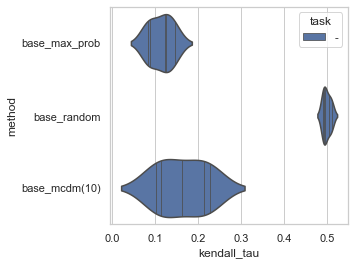

In [62]:
from spred.analytics import plot_evaluation_metric
plot_evaluation_metric(result_db, "kendall_tau")

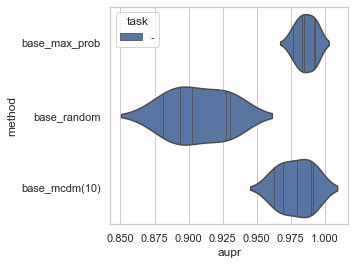

In [65]:
plot_evaluation_metric(result_db, "aupr")